Targets: 
1. Since the last model was not able to converge well, we need to increase the efficiency of the model. We will apply Batch Normalization just before every Convolution layer except input layer.

Results: 
1. Best Train accuracy: 99.49% (15th epoch)
2. Best Test accuracy:  99.17% (15th epoch)
3. Parameters: 7878

Analysis:
1. Using batch normalization definitely helped improve the convergence and training accuracy of the model.
2. We can see model is overfitting now.
3. In order to deal with this, we need to use regularization techniques like drop out or data augmentation which may help reduce the gap between training and validation accuracy.

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cblock1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, bias=False),    # Input -  28x28x1, Output -  28x28x8, RF - 3x3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 10, 3, padding=1, bias=False),   # Input -  28x28x8, Output - 28x28x10, RF - 5x5
            nn.ReLU(),
        )

        self.tblock1 = nn.Sequential(
            nn.MaxPool2d(2, 2),                           # Input - 28x28x10, Output - 14x14x10, RF - 6x6
        )

        self.cblock2 = nn.Sequential(
            nn.BatchNorm2d(10),
            nn.Conv2d(10, 16, 3, padding=1, bias=False),  # Input - 14x14x10, Output - 14x14x16, RF - 10x10
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),  # Input - 14x14x16, Output - 14x14x16, RF - 14x14
            nn.ReLU(),
        )

        self.tblock2 = nn.Sequential(
            nn.MaxPool2d(2, 2),                           # Input - 14x14x16, Output -   7x7x16, RF - 16x16
        )

        self.cblock3 = nn.Sequential(
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),  # Input -   7x7x16, Output -   7x7x16, RF - 24x24
            nn.ReLU(),
        )

        self.outblock = nn.Sequential(
            nn.AvgPool2d(7, 7),                           # Input -   7x7x16, Output -   1x1x16, RF - 48x48
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 10, 1),
            nn.Flatten(),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.cblock1(x)
        x = self.tblock1(x)
        x = self.cblock2(x)
        x = self.tblock2(x)
        x = self.cblock3(x)
        x = self.outblock(x)
        return x

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4           [-1, 10, 28, 28]             720
              ReLU-5           [-1, 10, 28, 28]               0
         MaxPool2d-6           [-1, 10, 14, 14]               0
       BatchNorm2d-7           [-1, 10, 14, 14]              20
            Conv2d-8           [-1, 16, 14, 14]           1,440
              ReLU-9           [-1, 16, 14, 14]               0
      BatchNorm2d-10           [-1, 16, 14, 14]              32
           Conv2d-11           [-1, 16, 14, 14]           2,304
             ReLU-12           [-1, 16, 14, 14]               0
        MaxPool2d-13             [-1, 16, 7, 7]               0
      BatchNorm2d-14             [

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Loss=0.014440962113440037 Batch_id=937 Accuracy=94.40: 100%|██████████| 938/938 [00:23<00:00, 40.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0789, Accuracy: 9764/10000 (97.64%)

EPOCH: 1


Loss=0.016070125624537468 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:23<00:00, 39.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9825/10000 (98.25%)

EPOCH: 2


Loss=0.07318544387817383 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:23<00:00, 39.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9852/10000 (98.52%)

EPOCH: 3


Loss=0.013162592425942421 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:23<00:00, 40.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


Loss=0.03514411300420761 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:23<00:00, 40.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9875/10000 (98.75%)

EPOCH: 5


Loss=0.00384502368979156 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:23<00:00, 39.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9901/10000 (99.01%)

EPOCH: 6


Loss=0.008670587092638016 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:23<00:00, 40.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9904/10000 (99.04%)

EPOCH: 7


Loss=0.011362140066921711 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:23<00:00, 39.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9900/10000 (99.00%)

EPOCH: 8


Loss=0.0011845447588711977 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:23<00:00, 40.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9902/10000 (99.02%)

EPOCH: 9


Loss=0.003929496742784977 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:23<00:00, 39.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9902/10000 (99.02%)

EPOCH: 10


Loss=0.0024382020346820354 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:24<00:00, 39.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9909/10000 (99.09%)

EPOCH: 11


Loss=0.0003071483806706965 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:23<00:00, 39.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9901/10000 (99.01%)

EPOCH: 12


Loss=0.0030142436735332012 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:23<00:00, 40.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9911/10000 (99.11%)

EPOCH: 13


Loss=0.0013990261359140277 Batch_id=937 Accuracy=99.49: 100%|██████████| 938/938 [00:23<00:00, 40.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9917/10000 (99.17%)

EPOCH: 14


Loss=0.00047643689322285354 Batch_id=937 Accuracy=99.49: 100%|██████████| 938/938 [00:23<00:00, 40.64it/s]



Test set: Average loss: 0.0276, Accuracy: 9917/10000 (99.17%)



Text(0.5, 1.0, 'Test Accuracy')

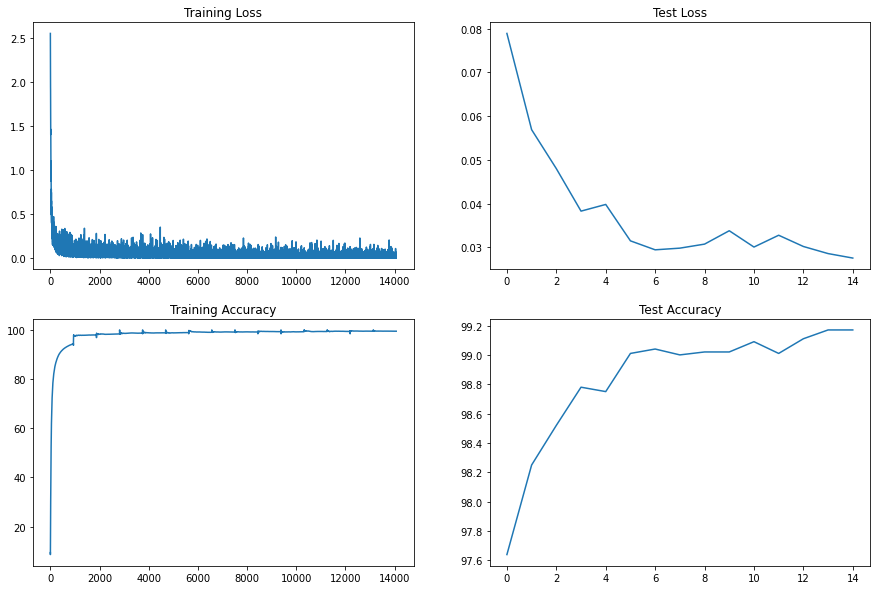

In [ ]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")